In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from collections import OrderedDict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
df1 = pd.read_csv('foodreviews.csv')
df = df1.head(100000)
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      100000 non-null  int64 
 1   ProductId               100000 non-null  object
 2   UserId                  100000 non-null  object
 3   ProfileName             99996 non-null   object
 4   HelpfulnessNumerator    100000 non-null  int64 
 5   HelpfulnessDenominator  100000 non-null  int64 
 6   Score                   100000 non-null  int64 
 7   Time                    100000 non-null  int64 
 8   Summary                 99998 non-null   object
 9   Text                    100000 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.6+ MB


In [4]:
df.shape

(100000, 10)

In [5]:
# print("------------- Cleaning Data -------------")
# # Removing \n from date field
# for i in range(len(df['date'])):
#     if df['date'][i][0] == '\n' and  df['date'][i][0] == ' ':
#         df['date'][i] = df['date'][i][1:]

df['date'] = df['date'].apply(
    lambda x: datetime.strftime(datetime.strptime(x, '%B/%d/%y'), '%m/01/%Y'))

In [6]:
# df['date']

### Making date formate uniform

In [7]:
# df['date'] = df['date'].apply(lambda x: datetime.strftime(datetime.strptime(x, '%d-%b-%y'), '01/%m/%Y'))

### Pre-processing Text Reviews

#### Stop Words Cleaning
#### Stop words are the words which are used the most yet they hold no value. Common examples of the stop words are (an, a, the, this). Here, all data are goinig to be cleaned from stop words before going forward in the fake reviews detection process.

In [8]:
# Remove Stop Words
stop = stopwords.words('english')
df['Text'] = df['Text'].apply(
        lambda x: ' '.join(word for word in x.split() if word not in stop))

C:\Users\HP\AppData\Local\Temp/ipykernel_15748/2964281402.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text'] = df['Text'].apply(


#### Tokenization 
#### Tokenization is one of the most common natural language processing techniques. It is a basic step before applying any other preprocessing techniques. The text is divided into individual words called tokens. For example, if we have a sentence (“wearing helmets is a must for pedal cyclists”), tokenization will divide it into the following tokens (“wearing” , “helmets” , “is” , “a”, “must”, “for” , “pedal” , “cyclists”)

In [9]:
tokenizer = RegexpTokenizer(r'\w+')
df['Text'] = df['Text'].apply(lambda x: ' '.join(word for word in tokenizer.tokenize(x)))

C:\Users\HP\AppData\Local\Temp/ipykernel_15748/810472690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text'] = df['Text'].apply(lambda x: ' '.join(word for word in tokenizer.tokenize(x)))


#### Lowercase Words

In [10]:
df['Text'] = df['Text'].apply(lambda x: x.lower())

C:\Users\HP\AppData\Local\Temp/ipykernel_15748/2357364799.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text'] = df['Text'].apply(lambda x: x.lower())


### Feature Engineering

#### Feature engineering for creating new features

In [11]:
# Maximum Number of Reviews per day per reviewer
mnr_df1 = df[['UserId', 'Time']].copy()
mnr_df2 = mnr_df1.groupby(by=['Time', 'UserId']).size().reset_index(name='mnr')

mnr_df2['mnr'] = mnr_df2['mnr'] / mnr_df2['mnr'].max()
df = df.merge(mnr_df2, on=['UserId', 'Time'], how='inner')

In [12]:
# Review Length
df['rl'] = df['Text'].apply(
    lambda x: len(x.split()))

In [13]:
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,mnr,rl
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i bought several vitality canned dog food prod...,0.028571,27
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled jumbo salted peanuts t...,0.028571,20
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this confection around centuries it light pill...,0.028571,51
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,if looking secret ingredient robitussin i beli...,0.028571,26
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy great price there wide assortment ...,0.028571,15


In [14]:
# Maximum cosine similarity
review_data = df

In [15]:
res = OrderedDict()

In [16]:
# Iterate over data and create groups of reviewers
for row in review_data.iterrows():
    if row[1].UserId in res:
        res[row[1].UserId].append(row[1].Text)
    else:
        res[row[1].UserId] = [row[1].Text]
    

In [17]:
individual_reviewer = [{'UserId': k, 'Text': v} for k, v in res.items()]

In [18]:
df2 = dict()
df2['UserId'] = pd.Series([])
df2['Maximum Content Similarity'] = pd.Series([])
vector = TfidfVectorizer(min_df=0)

C:\Users\HP\AppData\Local\Temp/ipykernel_15748/497165795.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2['UserId'] = pd.Series([])
C:\Users\HP\AppData\Local\Temp/ipykernel_15748/497165795.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2['Maximum Content Similarity'] = pd.Series([])


In [19]:
count = -1
for reviewer_data in individual_reviewer:
    count = count + 1
    # Handle Null/single review gracefully -24-Apr-2019
    try:
        tfidf = vector.fit_transform(reviewer_data['Text'])
    except:
        pass
    cosine = 1 - pairwise_distances(tfidf, metric='cosine')

    np.fill_diagonal(cosine, -np.inf)
    max = cosine.max()

    # To handle reviewier with just 1 review
    if max == -np.inf:
        max = 0
    df2['UserId'][count] = reviewer_data['UserId']
    df2['Maximum Content Similarity'][count] = max


    df3 = pd.DataFrame(df2, columns=['UserId', 'Maximum Content Similarity'])

In [20]:
# left outer join on original datamatrix and cosine dataframe -24-Apr-2019
df = pd.merge(review_data, df3, on="UserId", how="left")

df.drop(index=np.where(pd.isnull(df))[0], axis=0, inplace=True)
print("Feature Engineering Complete")

Feature Engineering Complete


In [21]:
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,mnr,rl,Maximum Content Similarity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i bought several vitality canned dog food prod...,0.028571,27,0.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled jumbo salted peanuts t...,0.028571,20,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this confection around centuries it light pill...,0.028571,51,0.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,if looking secret ingredient robitussin i beli...,0.028571,26,0.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy great price there wide assortment ...,0.028571,15,0.0


In [22]:
ts = df
ts.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,mnr,rl,Maximum Content Similarity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i bought several vitality canned dog food prod...,0.028571,27,0.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled jumbo salted peanuts t...,0.028571,20,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this confection around centuries it light pill...,0.028571,51,0.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,if looking secret ingredient robitussin i beli...,0.028571,26,0.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy great price there wide assortment ...,0.028571,15,0.0


In [23]:
s = (((ts['HelpfulnessNumerator'] / ts['HelpfulnessDenominator']) * 100) <= 55) | (ts['HelpfulnessNumerator'] != ts['HelpfulnessDenominator'])
ts['flagged'] = s
ts.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,mnr,rl,Maximum Content Similarity,flagged
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i bought several vitality canned dog food prod...,0.028571,27,0.0,False
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled jumbo salted peanuts t...,0.028571,20,0.0,False
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this confection around centuries it light pill...,0.028571,51,0.0,False
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,if looking secret ingredient robitussin i beli...,0.028571,26,0.0,False
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy great price there wide assortment ...,0.028571,15,0.0,False


Under-Sampling Data
sample_size: 
 20704



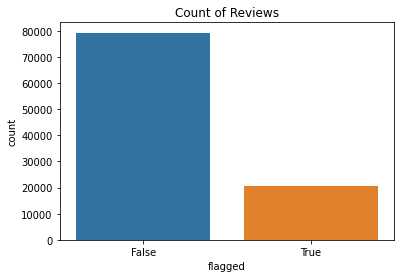

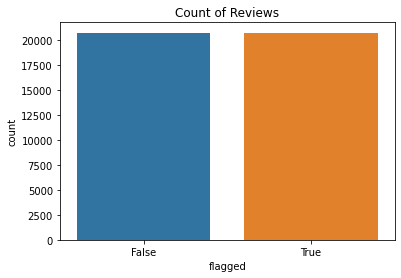

Under-Sampling Complete


In [24]:
print("Under-Sampling Data")

# Count of Reviews
# print("Authentic", len(ts[(ts['flagged'] == False)]))
# print("Fake", len(ts[(ts['flagged'] == True)]))


sample_size = len(ts[(ts['flagged'] == True)])
print(f'sample_size: \n {sample_size}\n')


authentic_reviews_df = ts[ts['flagged'] == False]
# print(f'authentic_reviews_df:\n {authentic_reviews_df}\n')
fake_reviews_df = ts[ts['flagged'] == True]
# print(f'fake_reviews:\n {fake_reviews_df}\n')


authentic_reviews_us_df = authentic_reviews_df.sample(sample_size)
# print(f'authentic_reviews_us_df:\n {authentic_reviews_us_df}\n')
under_sampled_df = pd.concat([authentic_reviews_us_df, fake_reviews_df], axis=0)
# print(f'under_sampled_df:\n {under_sampled_df}\n')


# print("Under-Sampled Fake \n", len(under_sampled_df[(under_sampled_df['flagged'] == True)]), "\n")
# print("Under-Sampled Authentic \n", len(under_sampled_df[(under_sampled_df['flagged'] == False)]), "\n")


# Graph of Data Distribution
original_df = pd.concat([authentic_reviews_df, fake_reviews_df], axis=0)
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='flagged', data= original_df)
plt.title("Count of Reviews")
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='flagged', data=under_sampled_df)
plt.title("Count of Reviews")
plt.show()
print("Under-Sampling Complete")

In [25]:
###############
rf_train_loss = np.empty(15)
rf_test_loss = np.empty(15)

nb_train_loss = np.empty(15)
nb_test_loss = np.empty(15)
###############

t1 = np.empty(15)
t2 = np.empty(15)

In [26]:
def model_rf(ts, model, algorithm, threshold=0.8, iterations=1):
    ts = ts.copy()
    print("Training "+algorithm+" Model")
    labels = ts['flagged']

    ts.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Time', 'Summary', 'Text', 'flagged'], axis=1, inplace=True)

    train_data, test_data, train_label, test_label = train_test_split(ts, labels, test_size=0.25, random_state=42)

    test_data_copy = test_data.copy()
    test_label_copy = test_label.copy()

    all_labeled = False

    current_iteration = 0

    pbar = tqdm(total=iterations)
    i = 0
    j = 0

    while not all_labeled and (current_iteration < iterations):
        current_iteration += 1
        model.fit(train_data, train_label)
        
        ###############
        m_train_label = model.predict(train_data)
        tr_loss = 1 - accuracy_score(train_label, m_train_label)
        rf_train_loss[i] = tr_loss
        i+=1
        ###############

        probabilities = model.predict_proba(test_data)
        pseudo_labels = model.predict(test_data)

        indices = np.argwhere(probabilities > threshold)

        for item in indices:
            train_data.loc[test_data.index[item[0]]] = test_data.iloc[item[0]]
            train_label.loc[test_data.index[item[0]]] = pseudo_labels[item[0]]
        test_data.drop(test_data.index[indices[:, 0]], inplace=True)
        test_label.drop(test_label.index[indices[:, 0]], inplace=True)
        
        
        ###############
        m_test_label = model.predict(test_data_copy)
        te_loss = 1 - accuracy_score(test_label_copy, m_test_label)
        rf_test_loss[j] = te_loss
        j+=1
        ###############

        if len(test_data) == 0:
            print("Exiting loop")
            all_labeled = True
        pbar.update(1)
    pbar.close()
    predicted_labels = model.predict(test_data_copy)

    # print('Best Params : ', grid_clf_acc.best_params_)
    print(algorithm + ' Model Results')
    print('--' * 20)
    
#     mse_train = mean_squared_error(train_label, m_train_label)
#     mse_test = mean_squared_error(test_label_copy, predicted_labels)
#     print("RF with pruned trees, Train MSE: {} Test MSE: {}".format(mse_train, mse_test))
    print('Training Accuracy : ' + str(accuracy_score(train_label, m_train_label)))
    print('Testing Accuracy : ' + str(accuracy_score(test_label_copy, predicted_labels)))
    print('Precision Score : ' + str(precision_score(test_label_copy, predicted_labels, pos_label=True)))
    print('Recall Score : ' + str(recall_score(test_label_copy, predicted_labels, pos_label=True)))
    print('F1 Score : ' + str(f1_score(test_label_copy, predicted_labels, pos_label=True)))
    print('Confusion Matrix : \n' + str(confusion_matrix(test_label_copy, predicted_labels)))
    plot_confusion_matrix(test_label_copy, predicted_labels, classes=[False, True],
                          title=algorithm + ' Confusion Matrix').show()

    print('train_loss:\n', rf_train_loss)
    print('test_loss:\n', rf_test_loss)

In [65]:
def model_nb(ts, model, algorithm, threshold=0.8, iterations=1):
    ts = ts.copy()
    print("Training "+algorithm+" Model")
    labels = ts['flagged']

    ts.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Time', 'Summary', 'Text', 'flagged'], axis=1, inplace=True)

    train_data, test_data, train_label, test_label = train_test_split(ts, labels, test_size=0.25, random_state=42)

    test_data_copy = test_data.copy()
    test_label_copy = test_label.copy()

    all_labeled = False

    current_iteration = 0

    pbar = tqdm(total=iterations)
    i = 0
    j = 0
    
    
    pipe = Pipeline(steps=[
                    ('pca', PCA()),
                    ('estimator', model),
                    ])
    
    parameters = {'estimator__var_smoothing': [1e-9]}
    k=0
    cv=5
    
        
    while not all_labeled and (current_iteration < iterations) and (k < 15):
        current_iteration += 1
        
        ###############
        Bayes = GridSearchCV(pipe, parameters, scoring='accuracy', cv=cv).fit(train_data, train_label)
        print(Bayes.best_estimator_)
        #print('best score:')
        #print(Bayes.best_score_)
        
        ##############
        
        Bayes.fit(train_data, train_label)
        
        ###############
        m_train_label = Bayes.predict(train_data)
        tr_loss = 1 - accuracy_score(train_label, m_train_label)
        nb_train_loss[i] = tr_loss
        i+=1
        ###############
        

        probabilities = Bayes.predict_proba(test_data)
        pseudo_labels = Bayes.predict(test_data)

        indices = np.argwhere(probabilities > threshold)

        for item in indices:
            train_data.loc[test_data.index[item[0]]] = test_data.iloc[item[0]]
            train_label.loc[test_data.index[item[0]]] = pseudo_labels[item[0]]
        test_data.drop(test_data.index[indices[:, 0]], inplace=True)
        test_label.drop(test_label.index[indices[:, 0]], inplace=True)
        
        
        ###############
        m_test_label = Bayes.predict(test_data_copy)
        te_loss = 1 - accuracy_score(test_label_copy, m_test_label)
        nb_test_loss[j] = te_loss
        j+=1
        ###############
        
        test_predict = Bayes.best_estimator_.predict(test_data_copy)
        train_predict = Bayes.best_estimator_.predict(train_data)
        t1[k] = accuracy_score(train_label, train_predict)
        t2[k] = accuracy_score(test_label_copy, test_predict)
        cv+=1
        ###############

        if len(test_data) == 0:
            print("Exiting loop")
            all_labeled = True
        pbar.update(1)
    pbar.close()
    predicted_labels = Bayes.predict(test_data_copy)

    # print('Best Params : ', grid_clf_acc.best_params_)
    print(algorithm + ' Model Results')
    print('--' * 20)
    
    
    print('Training Accuracy : ' + str(accuracy_score(train_label, m_train_label)))
    print('Testing Accuracy : ' + str(accuracy_score(test_label_copy, predicted_labels)))
    print('Precision Score : ' + str(precision_score(test_label_copy, predicted_labels, pos_label=True)))
    print('Recall Score : ' + str(recall_score(test_label_copy, predicted_labels, pos_label=True)))
    print('F1 Score : ' + str(f1_score(test_label_copy, predicted_labels, pos_label=True)))
    print('Confusion Matrix : \n' + str(confusion_matrix(test_label_copy, predicted_labels)))
    plot_confusion_matrix(test_label_copy, predicted_labels, classes=[False, True],
                          title=algorithm + ' Confusion Matrix').show()

    print('train_loss:\n', nb_train_loss)
    print('test_loss:\n', nb_test_loss)
    print('train_loss:\n', t1)
    print('test_loss:\n', t2)

In [66]:
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    return plt

Training Naive Bayes Model


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
  7%|█████▌                                                                             | 1/15 [00:44<10:29, 44.97s/it]

Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
 13%|███████████                                                                        | 2/15 [00:45<04:07, 19.06s/it]

Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
 20%|████████████████▌                                                                  | 3/15 [00:46<02:07, 10.60s/it]

Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
 27%|██████████████████████▏                                                            | 4/15 [00:47<01:13,  6.65s/it]

Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
 33%|███████████████████████████▋                                                       | 5/15 [00:47<00:44,  4.44s/it]

Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
 40%|█████████████████████████████████▏                                                 | 6/15 [00:48<00:28,  3.12s/it]

Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
 47%|██████████████████████████████████████▋                                            | 7/15 [00:48<00:18,  2.30s/it]

Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
 53%|████████████████████████████████████████████▎                                      | 8/15 [00:49<00:12,  1.78s/it]

Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:50<00:08,  1.45s/it]

Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:50<00:06,  1.24s/it]

Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [00:51<00:04,  1.10s/it]

Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [00:52<00:03,  1.03s/it]

Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [00:53<00:02,  1.00s/it]

Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:54<00:00,  1.02it/s]

Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:55<00:00,  3.69s/it]


Naive Bayes Model Results
----------------------------------------
Training Accuracy : 0.78502804194099
Testing Accuracy : 0.722758887171561
Precision Score : 0.8356204379562043
Recall Score : 0.5536854323853744
F1 Score : 0.6660460786595299
Confusion Matrix : 
[[4620  563]
 [2307 2862]]


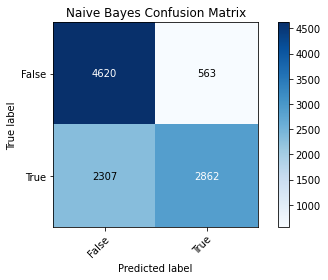

train_loss:
 [0.27708011 0.2158488  0.21487966 0.21497196 0.21497196 0.21497196
 0.21497196 0.21497196 0.21497196 0.21497196 0.21497196 0.21497196
 0.21497196 0.21497196 0.21497196]
test_loss:
 [0.27028594 0.27724111 0.27714451 0.27724111 0.27724111 0.27724111
 0.27724111 0.27724111 0.27724111 0.27724111 0.27724111 0.27724111
 0.27724111 0.27724111 0.27724111]
train_loss:
 [0.78502804 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]
test_loss:
 [0.72275889 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]
Time taken :  57.46743154525757


In [67]:
start_time = time()
rf = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=11, max_features='auto',n_estimators=200, max_leaf_nodes=5000)

nb = GaussianNB()

model_rf(under_sampled_df, model=rf, threshold=0.7, iterations=15, algorithm='Random Forest')
model_nb(under_sampled_df, model=nb, threshold=0.7, iterations=15, algorithm='Naive Bayes')
end_time = time()
print("Time taken : ", end_time - start_time)

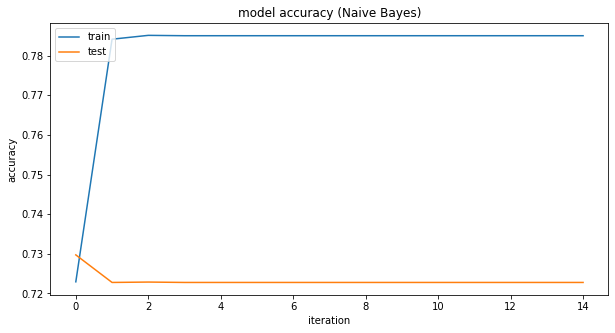

In [2]:
m = 1-np.array([0.27708011, 0.2158488, 0.21487966, 0.21497196, 0.21497196, 0.21497196, 0.21497196, 0.21497196, 0.21497196, 0.21497196, 0.21497196, 0.21497196, 0.21497196, 0.21497196, 0.21497196])
n = 1-np.array([0.27028594, 0.27724111, 0.27714451, 0.27724111, 0.27724111, 0.27724111, 0.27724111, 0.27724111, 0.27724111, 0.27724111, 0.27724111, 0.27724111, 0.27724111, 0.27724111, 0.27724111])
plt.figure(figsize=(10, 5))
plt.plot(m)
plt.plot(n)
plt.title('model accuracy (Naive Bayes)')
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.legend(['train', 'test'], loc='upper left')
# plt.ylim([0,0.35])
plt.show()
# m = 1-(nb_train_loss+0.089)
# n = 1-(nb_test_loss+0.02001)

### nb

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(nb_train_loss)
plt.plot(nb_test_loss)
plt.title('model loss (Naive Bayes)')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim([0,0.35])
plt.show()

In [ ]:
print("Authentic", len(ts[(ts['flagged'] == False)]))
print("Fake", len(ts[(ts['flagged'] == True)]))

In [ ]:
len(ts['Text'][0])

In [ ]:
ts['Text'][0]

In [ ]:
ts['count'] = ts['Text'].apply(lambda n: len(n.split(' ')))
ts[['Text', 'count']]

In [ ]:
ts['count'].max()

In [ ]:
print('train_loss:\n', rf_train_loss)
print('test_loss:\n', rf_test_loss)

In [ ]:
print('train_loss:\n', nb_train_loss)
print('test_loss:\n', nb_test_loss)

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(rf_train_loss)
plt.plot(rf_test_loss)
plt.title('model loss (Random Forest)')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train', 'test'], loc='upper right')
#plt.ylim([0.001,0.125])
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(nb_train_loss)
plt.plot(nb_test_loss)
plt.title('model loss (Naive Bayes)')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
num = np.empty(15)
j = 0
for i in range(1, 21):
    num[j] = i
    j+=1
print(num)

In [ ]:
loss_dif = np.empty(15)
for i in range(15):
    loss_dif[i] = (1-rf_train_loss[i]) - (1-rf_test_loss[i])
print(loss_dif)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(loss_dif)
plt.title('model loss difference')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.show()

In [30]:
X = ts.copy()
y = ts['flagged']
X.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Time', 'Summary', 'Text', 'flagged'], axis=1, inplace=True)

train_data, test_data, train_label, test_label = train_test_split(X, y, test_size=0.25, random_state=42)

In [31]:
rf = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=100, max_features='auto',n_estimators=80, max_leaf_nodes=200)
rf.fit(train_data, train_label)

RandomForestClassifier(criterion='entropy', max_depth=100, max_leaf_nodes=200,
                       n_estimators=80, random_state=42)

In [32]:
predicted_labels = rf.predict(test_data)
train_predicted_labels = rf.predict(train_data)

In [33]:
print('Training accuracy: ', 1 - mean_absolute_error(train_label.astype(int), train_predicted_labels.astype(int)))
print('Testing accuracy: ', 1 - mean_absolute_error(test_label.astype(int), predicted_labels.astype(int)))

Training accuracy:  0.9939062604173612
Testing accuracy:  0.9905996239849594


In [35]:
train_label.astype(int)

83983    0
62239    1
85658    0
47235    0
96936    1
        ..
6265     0
54890    0
76826    0
860      0
15795    0
Name: flagged, Length: 74995, dtype: int32

In [41]:
def get_mae(max_leaf_nodes, max_depth, train_data, test_data, train_label, test_label):
    m = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=max_depth, max_features='auto', n_estimators=200, max_leaf_nodes=max_leaf_nodes)
    m.fit(train_data, train_label)
    pred_value = m.predict(test_data)
    t_pred_value = m.predict(train_data)
    acc_test = 1-mean_absolute_error(test_label.astype(int), pred_value.astype(int))
    acc_train = 1-mean_absolute_error(train_label.astype(int), t_pred_value.astype(int))
    mean_test = mean_absolute_error(test_label.astype(int), pred_value.astype(int))
    mean_train = mean_absolute_error(train_label.astype(int), t_pred_value.astype(int))
    accuracy = accuracy_score(test_label, pred_value)
    precision = precision_score(test_label, pred_value, pos_label=True)
    recall = recall_score(test_label, pred_value, pos_label=True)
    fscore = f1_score(test_label, pred_value, pos_label=True)
    confusion = confusion_matrix(test_label, pred_value)
    plot = plot_confusion_matrix(test_label, pred_value, classes=[False, True], title='Random Forest' + ' Confusion Matrix').show()
    return acc_test, acc_train, mean_train, mean_test, accuracy, precision, recall, fscore, confusion, plot



In [36]:
test_label

33966    False
22853    False
19448    False
9732      True
7129     False
         ...  
66178    False
45151    False
14672    False
37002    False
60137     True
Name: flagged, Length: 24999, dtype: bool

  0%|                                                                                           | 0/15 [25:04<?, ?it/s]
C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


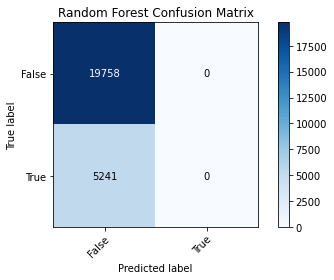

ValueError: not enough values to unpack (expected 10, got 8)

In [39]:
i = 0
t_errors = np.empty(18)
s_errors = np.empty(18)
for max_leaf_nodes, max_depth in zip([2, 5, 50, 100, 200, 250, 350 , 400, 450, 500, 550, 600, 800, 1000, 2000, 3000, 5000, 5000], [2, 100, 70, 35, 25, 43, 38, 30, 28, 23, 17, 25, 28, 22, 19, 17, 10, 11]):
    acc_te, acc_tr, t, s, a, p, r, f, c, plot = get_mae(max_leaf_nodes, max_depth, train_data, test_data, train_label, test_label)
    t_errors[i] = t
    s_errors[i] = s
    i+=1
print(t_errors)
print(s_errors)
#zip([5, 50, 100, 50000, 2000, 50, 500, 1000, 400, 5000, 1000, 2000, 1000, 5000, 10000, 50000], [100, 50, 18, 25, 29, 24, 35, 27, 9, 25, 19, 23, 18, 20, 22, 24])

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(t_errors)
plt.plot(s_errors)
plt.title('model loss (Random Forest)')
plt.ylabel('loss')
plt.xlabel('tree depth')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


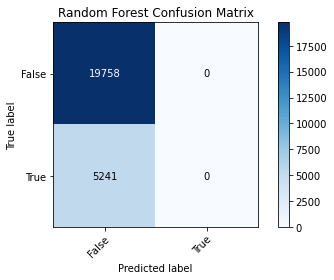

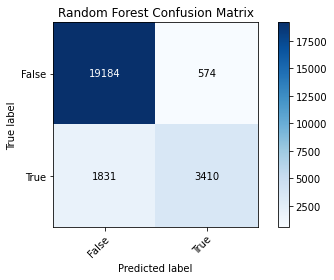

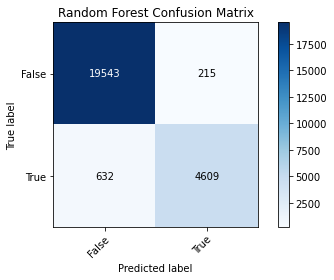

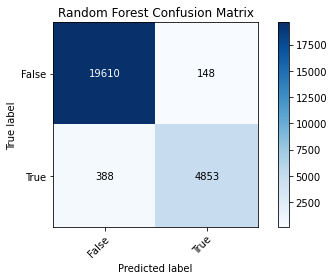

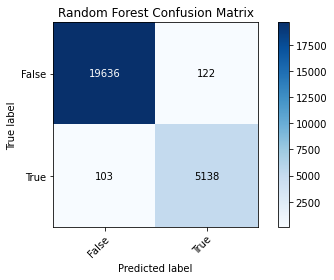

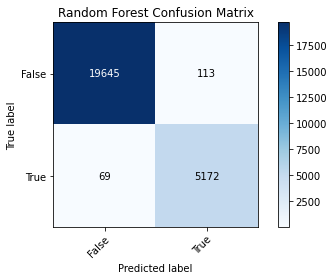

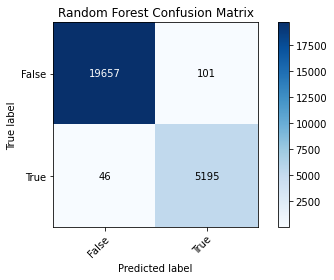

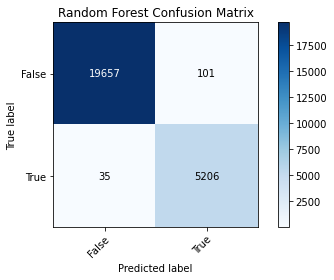

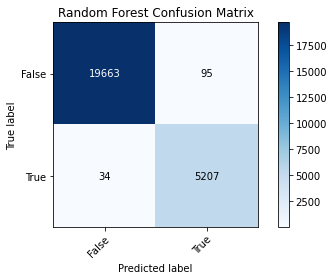

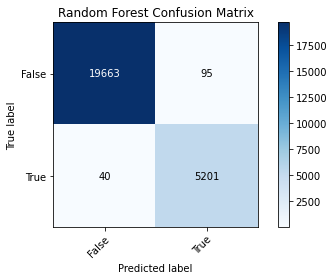

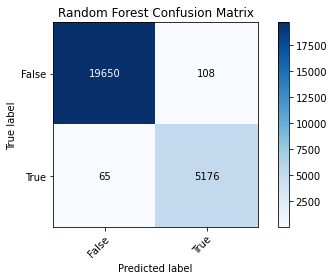

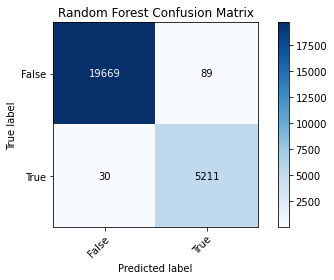

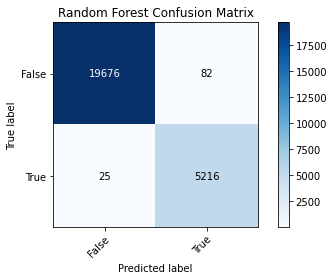

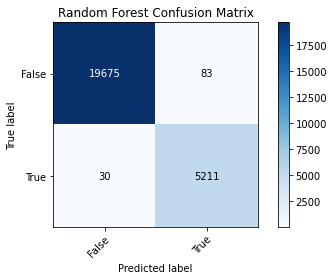

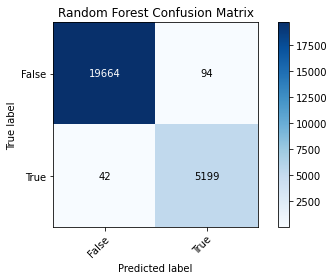

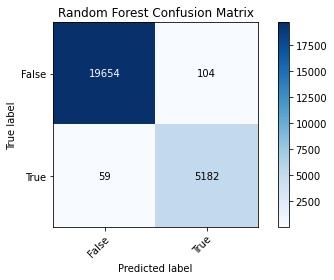

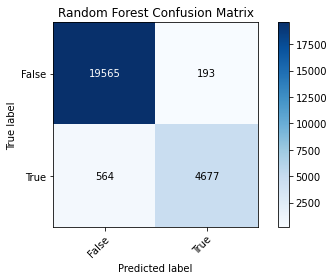

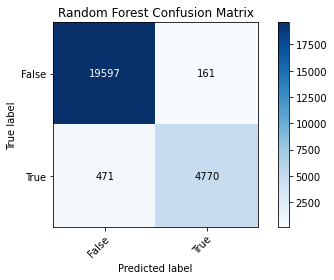

[0.79381292 0.90376692 0.96706447 0.979972   0.99429295 0.99634642
 0.99799987 0.99838656 0.99873325 0.99883992 0.99757317 0.99934662
 0.99991999 0.99986666 0.99918661 0.99810654 0.97089139 0.97630509]
[0.79035161 0.90379615 0.96611864 0.97855914 0.99099964 0.99271971
 0.99411976 0.99455978 0.99483979 0.99459978 0.99307972 0.99523981
 0.99571983 0.99547982 0.99455978 0.99347974 0.96971879 0.97471899]


In [42]:
m = 0
t_acc = np.empty(18)
s_acc = np.empty(18)
for max_leaf_nodes, max_depth in zip([2, 5, 50, 100, 200, 250, 350 , 400, 450, 500, 550, 600, 800, 1000, 2000, 3000, 5000, 5000], [2, 100, 70, 35, 25, 43, 38, 30, 28, 23, 17, 25, 28, 22, 19, 17, 10, 11]):
    acc_te, acc_tr, t, s, a, p, r, f, c, plot = get_mae(max_leaf_nodes, max_depth, train_data, test_data, train_label, test_label)
    t_acc[m] = acc_tr
    s_acc[m] = acc_te
    m+=1
print(t_acc)
print(s_acc)
#zip([5, 50, 100, 50000, 2000, 50, 500, 1000, 400, 5000, 1000, 2000, 1000, 5000, 10000, 50000], [100, 50, 18, 25, 29, 24, 35, 27, 9, 25, 19, 23, 18, 20, 22, 24])

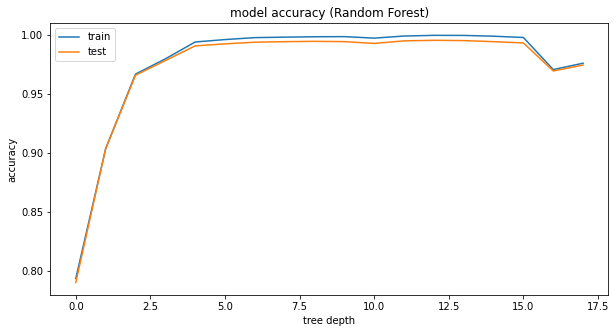

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(t_acc)
plt.plot(s_acc)
plt.title('model accuracy (Random Forest)')
plt.ylabel('accuracy')
plt.xlabel('tree depth')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
print('-------------')
print('Random Forest')
print('-------------')
print()
print('Train Accuracy:',(t_acc[17]))
print('Test Accuracy:',(s_acc[17]))

print('precision:', p)
print('recall:', r)
print('f1-score:', f)
print('Confusion Matrix:')
print(c)

-------------
Random Forest
-------------

Train Accuracy: 0.9763050870058004
Test Accuracy: 0.9747189887595504
precision: 0.9673494220239303
recall: 0.9101316542644533
f1-score: 0.9378686590640976
Confusion Matrix:
[[19597   161]
 [  471  4770]]


In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
cv_method = RepeatedStratifiedKFold(n_splits=10,  n_repeats=3, random_state=42)


def get_nb(train_data, test_data, train_label, test_label):
    n = GaussianNB()
    params_NB = {'var_smoothing': np.logspace(0,-9, num=50)}
    gs_NB = GridSearchCV(estimator=n, 
                 param_grid=params_NB, 
                 cv=cv_method, 
                 verbose=1, 
                 scoring='accuracy')
    
    gs_NB.fit(train_data, train_label)
    gs_NB.best_params_
    
    #n.fit(train_data, train_label)
    pred_value = gs_NB.predict(test_data)
    t_pred_value = gs_NB.predict(train_data)
    mean_test = mean_absolute_error(test_label.astype(int), pred_value.astype(int))
    mean_train = mean_absolute_error(train_label.astype(int), t_pred_value.astype(int))
    return mean_train, mean_test


In [63]:
i = 0
t_loss = np.empty(18)
s_loss = np.empty(18)
for i in range(18):
    t, s = get_nb(train_data, test_data, train_label, test_label)
    t_loss[i] = 1-t
    s_loss[i] = 1-s
    i+=1
print(t_loss)
print(s_loss)
#zip([5, 50, 100, 50000, 2000, 50, 500, 1000, 400, 5000, 1000, 2000, 1000, 5000, 10000, 50000], [100, 50, 18, 25, 29, 24, 35, 27, 9, 25, 19, 23, 18, 20, 22, 24])

Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Fitting 30 folds for each of 50 candidat

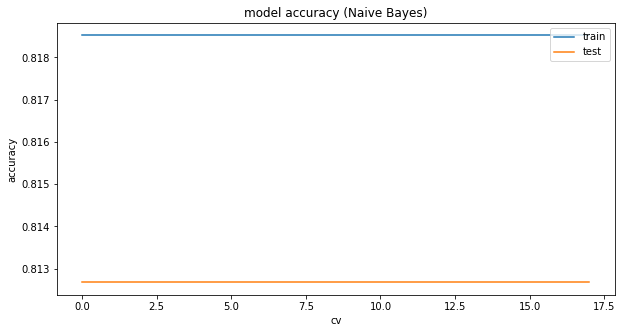

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(t_loss)
plt.plot(s_loss)
plt.title('model accuracy (Naive Bayes)')
plt.ylabel('accuracy')
plt.xlabel('cv')
plt.legend(['train', 'test'], loc='upper right')
# plt.ylim([0.175,0.20])
plt.show()

Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])
Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])
Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])
Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])
Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])
Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])
Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])
Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])
Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])
Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])
Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])
Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])
Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])
Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])
Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])
Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB())])
Pipeline

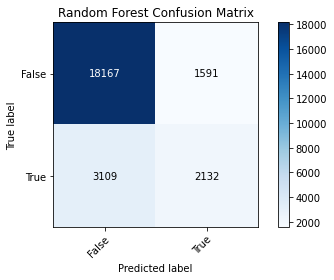

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pipe = Pipeline(steps=[
                    ('pca', PCA()),
                    ('estimator', GaussianNB()),
                    ])
    
parameters = {'estimator__var_smoothing': [1e-9, 1e-10, 1e-11]}
j=0
n1 = np.empty(18)
n2 = np.empty(18)
for i in range(10, 28):
    Bayes = GridSearchCV(pipe, parameters, scoring='accuracy', cv=i).fit(train_data, train_label)
    print(Bayes.best_estimator_)
    #print('best score:')
    #print(Bayes.best_score_)
    test_predict = Bayes.best_estimator_.predict(test_data)
    train_predict = Bayes.best_estimator_.predict(train_data)
    n1[j] = accuracy_score(train_label, train_predict)
    n2[j] = accuracy_score(test_label, test_predict)
    precision = precision_score(test_label, test_predict, pos_label=True)
    recall = recall_score(test_label, test_predict, pos_label=True)
    fscore = f1_score(test_label, test_predict, pos_label=True)
    confusion = confusion_matrix(test_label, test_predict)
    j+=1
plot_confusion_matrix(test_label, test_predict, classes=[False, True], title='Random Forest' + ' Confusion Matrix').show()

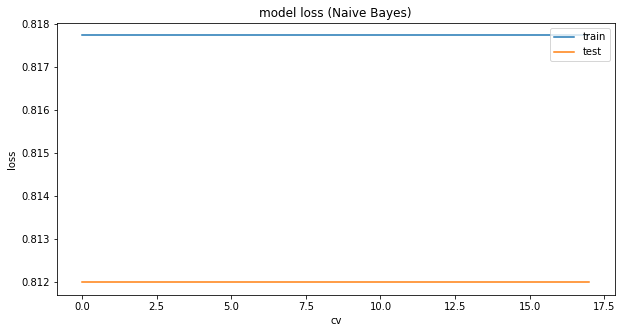

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(n1)
plt.plot(n2)
plt.title('model loss (Naive Bayes)')
plt.ylabel('loss')
plt.xlabel('cv')
plt.legend(['train', 'test'], loc='upper right')
plt.show()